<a href="https://colab.research.google.com/github/pacslab/serverless-temporal-perf-modeling/blob/main/parsing-experiment-transient.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Parsing Multiple Files for Modeling Transient Behaviour of Serverless Computing

In this file, we aim to average out several executions of the same workload pattern to get the average behavior of the platform.

If you are running this notebook from environments like **Google Colab**, uncomment the following cell in your first execution to download everything from the [Github repository](https://github.com/pacslab/serverless-temporal-perf-modeling).

In [1]:
# If running from Google Colab, uncomment these to fetch the data from Github:
# !git init
# !git remote add origin https://github.com/pacslab/serverless-temporal-perf-modeling.git
# !git pull origin main
# !pip install -r requirements.txt

# !sudo apt install font-manager
# !sudo apt-get install msttcorefonts -qq
# !rm ~/.cache/matplotlib -fr

In [2]:
# import matplotlib
# sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])


In [3]:
%load_ext autoreload
%autoreload 2
# Imports

import os

import pacsltk.pacs_util as pacs_util
import trans_exp_parser as exp_parser
import trans_perf_model

import pandas as pd

pacs_util.prepare_matplotlib_cycler()

# To avoid type 3 fonts: http://phyletica.org/matplotlib-fonts/
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import pacsltk
print(pacsltk.__version__)

0.2.0


In [4]:
csv_file_folder = os.path.join('results', 'exp1')
csv_file_list = [i for i in os.listdir(csv_file_folder) if '.csv' in i]

idle_mins_before_kill = 10
step_seconds = 10

tdfs = []
dfcs = []
for csv_filename in csv_file_list:
    csv_file = os.path.join(csv_file_folder, csv_filename)

    df = exp_parser.read_csv_file(csv_file)
    df = exp_parser.preprocess_df(df)
    tdf, time_idx = exp_parser.time_preprocess_df(df)

    parse_results = exp_parser.parse_instance_info(df, idle_mins_before_kill)
    # load results into local variables
    locals().update(parse_results)

    # tdf['instance_count'] = 
    df_counts = exp_parser.parse_counting_info(df, df_inst, step_seconds=step_seconds)
    df_counts['rps'] = tdf['is_cold'].resample('{}S'.format(step_seconds)).count() / step_seconds
    df_counts['p_cold'] = tdf['is_cold'].resample('{}S'.format(step_seconds)).mean()
    df_counts['rt'] = tdf['client_elapsed_time'].resample('{}S'.format(step_seconds)).mean() / 1000

    df_counts_smooth = df_counts.resample('T').mean()

    # Append the results to be used later
    tdfs.append(tdf)
    dfcs.append(df_counts_smooth)

In [5]:
tdfs[0].head()

,is_cold,inst_id,vm_id,elapsed_time,aws_duration,client_elapsed_time,client_start_time_dt,client_end_time_dt
client_start_time_dt,,,,,,,,
0 days 00:00:00,True,sandbox-cba6dc,sandbox-root-CxJkRb,2032.337402,2033.02,2427.139521,2020-03-29 23:34:41.874080,2020-03-29 23:34:44.301220
0 days 00:00:03.056426,False,sandbox-cba6dc,sandbox-root-CxJkRb,1842.882568,1843.52,1931.809187,2020-03-29 23:34:44.930506,2020-03-29 23:34:46.862315
0 days 00:00:03.381933,True,sandbox-0accc0,sandbox-root-tH885o,1965.697266,1966.37,2528.977871,2020-03-29 23:34:45.256013,2020-03-29 23:34:47.784991
0 days 00:00:04.001833,True,sandbox-fb1c5c,sandbox-root-EO5dtO,2000.459961,2001.12,2599.175215,2020-03-29 23:34:45.875913,2020-03-29 23:34:48.475089
0 days 00:00:06.978754,False,sandbox-fb1c5c,sandbox-root-EO5dtO,1850.534912,1851.19,1943.536282,2020-03-29 23:34:48.852834,2020-03-29 23:34:50.796371


In [6]:
dfcs[0].tail()

,instance_count,running_count,running_warm_count,idle_count,utilization,rps,p_cold,rt
0 days 00:55:00,51.0,17.500000,17.500000,33.500000,0.343137,7.616667,0.0,2.059014
0 days 00:56:00,51.0,14.166667,14.166667,36.833333,0.277778,5.650000,0.0,2.056468
0 days 00:57:00,51.0,6.833333,6.833333,44.166667,0.133987,3.066667,0.0,2.053080
0 days 00:58:00,51.0,1.666667,1.666667,49.333333,0.032680,1.033333,0.0,2.048078
0 days 00:59:00,51.0,1.000000,1.000000,50.000000,0.019608,0.600000,0.0,2.061483


In [7]:
# Getting the average behaviour
dfc = pd.DataFrame()
for col_name in dfcs[0].columns:
    tmpdf = pd.DataFrame()
    for i in range(len(dfcs)):
        tmpdf[col_name + "_" + str(i)] = dfcs[i][col_name]

    dfc[col_name] = tmpdf.mean(axis=1)

dfc.head()
csv_filename = "exp01-average.csv"
csv_file = os.path.join('results', csv_filename)
dfc.to_csv(csv_file)

In [8]:
mdf = dfc

# How many minutes to predict into future
pred_mins = 5

warm_service_time = df[df['is_cold'] == False]['client_elapsed_time'].mean() / 1000
cold_service_time = df[df['is_cold'] == True]['client_elapsed_time'].mean() / 1000
idle_time_before_kill = 10*60
max_t = 60

trans_predictions = []
for idx in range(mdf.shape[0] - pred_mins):
    pred_rpss = mdf['rps'].iloc[idx:idx+pred_mins].values
    init_server_count = int(mdf['instance_count'].iloc[idx])
    props = None
    for i in range(pred_mins):
        arrival_rate = pred_rpss[i]
        props, _ = trans_perf_model.get_sls_props_transient(arrival_rate, warm_service_time, 
                cold_service_time, idle_time_before_kill, max_t=max_t, 
                init_server_count=init_server_count)
        init_server_count = int(props['avg_server_count'])
        props['idx'] = mdf.index[idx]
        
    props['last_pred'] = pred_rpss[-1]
    trans_predictions.append(props)

pred_df = pd.DataFrame(trans_predictions)
pred_df.set_index('idx', inplace=True)
# shift to see predictions
from datetime import timedelta
pred_df.index = pred_df.index + timedelta(minutes=5)

## Making Plots to Compare Model and Experiments

In [9]:
import matplotlib.ticker as mticker
import datetime
import math

# Prepare for plots
figs_folder = "figs"

def get_fig_path(x): return (os.path.join(figs_folder, "exp" +
                                          x + ".png"), os.path.join(figs_folder, "exp" + x + ".pdf"))

def tmp_fig_save(fig_name):
    paths = get_fig_path(fig_name)
    plt.savefig(paths[0], dpi=300)
    plt.savefig(paths[1])

def plot_configs(ylab, is_texp=True):
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.xlabel("Experiment Time (MM:SS)")
    plt.ylabel(ylab)
    plt.gcf().subplots_adjust(left=0.17, bottom=0.22)
    if is_texp:
        pacs_util.fix_timedelta(1e-3)

    def timeTicks(x, pos):
        # d = datetime.timedelta(seconds=x/1e9)
        # s = str(d)
        # return ":".join(s.split(":")[1:3])
        remaining_seconds = x / 1e9
        minutes = math.floor(remaining_seconds / 60)
        seconds = math.floor(remaining_seconds - minutes * 60)
        return f"{minutes:02d}:{seconds:02d}"

    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(base=10*60*1e9))
    plt.gca().xaxis.set_minor_locator(mticker.MultipleLocator(base=1*60*1e9))
    formatter = mticker.FuncFormatter(timeTicks)
    plt.gca().xaxis.set_major_formatter(formatter)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


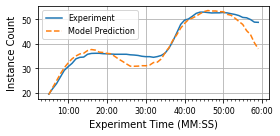

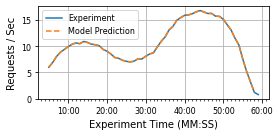

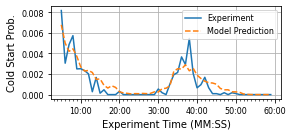

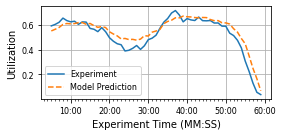

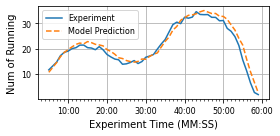

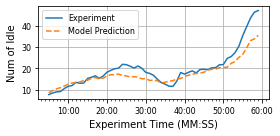

In [10]:
# Remove the parts we don't have a prediction for
def make_plots(mdf, pred_df, prefix=None):
    mdf = mdf[mdf.index >= pred_df.index.min()]

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['instance_count'], label='Experiment')
    plt.plot(pred_df['avg_server_count'], label='Model Prediction')
    plot_configs("Instance Count")
    if prefix is not None:
        tmp_fig_save(prefix+"_instance_count")

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['rps'], label='Experiment')
    plt.plot(pred_df['last_pred'].shift(-1), label='Model Prediction')
    plot_configs("Requests / Sec")
    if prefix is not None:
        tmp_fig_save(prefix+"_rps")

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['p_cold'], label='Experiment')
    plt.plot(pred_df['cold_prob'], label='Model Prediction')
    plot_configs("Cold Start Prob.")
    if prefix is not None:
        tmp_fig_save(prefix+"_p_cold")

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['utilization'], label='Experiment')
    plt.plot(pred_df['avg_utilization'], label='Model Prediction')
    plot_configs("Utilization")
    if prefix is not None:
        tmp_fig_save(prefix+"_utilization")

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['running_count'], label='Experiment')
    plt.plot(pred_df['avg_running_count'], label='Model Prediction')
    plot_configs("Num of Running")
    if prefix is not None:
        tmp_fig_save(prefix+"_running_count")

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['idle_count'], label='Experiment')
    plt.plot(pred_df['avg_idle_count'], label='Model Prediction')
    plot_configs("Num of Idle")
    if prefix is not None:
        tmp_fig_save(prefix+"_idle_count")

make_plots(mdf, pred_df, prefix='01')

# Download Figures

This section will execute the necessary code for downloading the figures generated in this notebook.

In [11]:
!zip figs.zip figs/*

from google.colab import files

files.download('figs.zip')

updating: figs/exp01_idle_count.pdf (deflated 3%)
updating: figs/exp01_idle_count.png (deflated 6%)
updating: figs/exp01_instance_count.pdf (deflated 3%)
updating: figs/exp01_instance_count.png (deflated 6%)
updating: figs/exp01_p_cold.pdf (deflated 3%)
updating: figs/exp01_p_cold.png (deflated 5%)
updating: figs/exp01_rps.pdf (deflated 3%)
updating: figs/exp01_rps.png (deflated 5%)
updating: figs/exp01_running_count.pdf (deflated 3%)
updating: figs/exp01_running_count.png (deflated 5%)
updating: figs/exp01_utilization.pdf (deflated 3%)
updating: figs/exp01_utilization.png (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>